# Multi-class classifier: MNIST images

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/msds621/blob/master/notebooks/deep-learning/5.multiclass-classifier-mnist.ipynb)

By [Terence Parr](https://explained.ai).

To demonstrate $k$ class classification instead of binary ($k=2$) classification, let's use the traditional MNIST digital image recognition problem. We'll again use a random forest model as a baseline classifier. Instead of a sigmoid on a single output neuron, $k$ class classifiers use $k$ neurons in the final layer and then a softmax computation instead of a single-output sigmoid. We see fairly decent recognition results with just 50 neurons. By using 500 neurons, we get slightly better results.

## Support code

In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from matplotlib import colors 

%config InlineBackend.figure_format = 'retina'

In [2]:
def plot_loss(history, ax=None, maxy=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    loss = history[:,0]
    val_loss = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_loss))
    ax.spines['top'].set_visible(False)    # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.plot(loss, label='train_loss')
    ax.plot(val_loss, label='val_loss')
    ax.legend(loc='upper right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
        
def plot_accur(history, ax=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epochs")
    accur = history[:,2]
    val_accur = history[:,3]
    ax.set_ylim(0,1.05)
    ax.plot(accur, label='accur')
    ax.plot(val_accur, label='val_accur')
    ax.spines['top'].set_visible(False)    # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.legend(loc='lower right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
        
def imgrid(images, digits, dim=(5,5), figsize=(4, 4)):
    fig, axes = plt.subplots(*dim, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        img_as_row = images[i]
        img28x28 = img_as_row.reshape(28,28)
        ax.axis('off') # don't show x, y axes
        ax.imshow(img28x28, cmap='Greys')
        ax.text(0, 8, digits[i], color='#313695', fontsize=15)

## Load data

Let's use a subset of the well-known MNIST handwritten digits data set. This problem is the "hello world" of image recognition for deep learning.  The images have 28x28 pixels for a total of 784 features if we flatten them into feature vectors. Each row in the data set will represent an image.

In [3]:
df_mnist = pd.read_csv("https://mlbook.explained.ai/data/mnist-10k-sample.csv.zip")
X = df_mnist.drop('digit', axis=1).values # get just pixels
y = df_mnist['digit'].values              # get just digit value

In [4]:
X.shape # There are 784 pixels per 28x28 image

(10000, 784)

In [5]:
# shuffle so that images for the digits are not grouped together
n = len(X)
idx = np.random.randint(0,n,n)
X = X[idx,:]
y = y[idx]

Using the handy function from above, let's display a sample of the images and their true known values. As you can see, there's a great deal of variety in how different people draw Hindu-Arabic numerals.

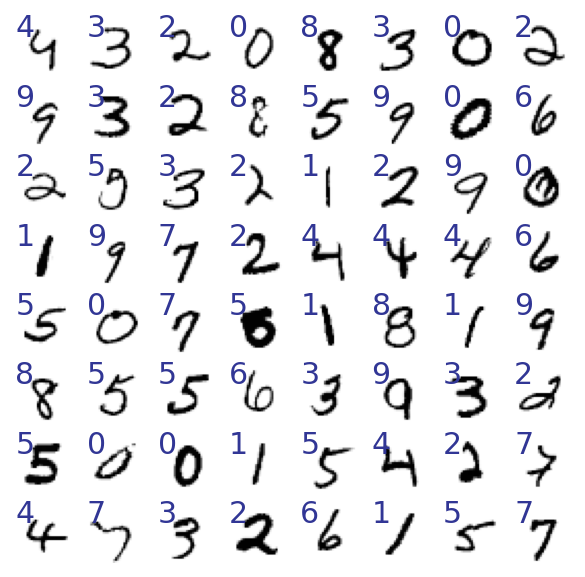

In [6]:
imgrid(X,digits=y,dim=(8,8),figsize=(5,5))

In order to measure the generality of our model, which is what we really care about, let's split the images 80/20 into training/validation sets:

In [7]:
X = torch.tensor(X).float()
y = torch.tensor(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Random forest baseline

It's also a good idea to get a baseline performance so that we know whether all of this neural network stuff is worth the hassle. In other words, if a random forest, which is easy to use and train, is good enough then we don't need the complexity of a neural network. Let's train a random forest classifier with a lot of trees. (`n_jobs=-1` just tells the scikit-learn library to compute the trees in parallel across multiple core.)

In [8]:
rf = RandomForestClassifier(n_estimators=900, n_jobs=-1)
rf.fit(X_train, y_train) 

RandomForestClassifier(n_estimators=900, n_jobs=-1)

Let's compute the accuracy of the model on both the training and validation sets:

In [9]:
y_train_accuracy = rf.score(X_train, y_train)
y_accuracy = rf.score(X_test, y_test)
y_train_accuracy, y_accuracy

(1.0, 0.9845)

The classifier gets 100% accuracy on the 8000 images of the training set and greater than 97% accuracy on the validation set. That's pretty good considering we didn't have to think much to get the classifier to work.

To get more detail about how well the model predicts each digit, let's look at the *confusion matrix* whose $(i,j)$ elements represent the count of records (images) known to be class $i$ but predicted to be in class $j$.  In this case, the column and row headers are the digits 0..9. The sklearn function `confusion_matrix` takes the true $y$ and compares it to the predicted $\hat{y}$ to yield a matrix:

In [10]:
y_pred = rf.predict(X_test)
conf = confusion_matrix(y_test, y_pred)
print(conf)

[[184   0   1   0   0   0   0   0   0   0]
 [  0 210   1   0   0   0   0   0   0   0]
 [  0   0 187   0   0   0   1   0   0   0]
 [  0   0   0 223   0   3   0   0   2   0]
 [  0   0   0   0 199   0   0   1   0   4]
 [  0   0   0   2   1 184   0   0   1   0]
 [  0   0   0   0   0   0 190   0   0   0]
 [  0   1   1   1   0   0   0 206   0   0]
 [  0   0   2   0   0   2   0   0 201   1]
 [  0   0   0   2   2   1   0   0   1 185]]


The correct predictions lie on the diagonal when $i=j$ because we have predicted the true value. Without labels that's a little bit harder to interpret so let's thrown into a data frame:

In [11]:
def showmatrix(conf):
    df_conf = pd.DataFrame(conf,
                       index=[f"$y$={i}" for i in range(0,9+1)],
                       columns=["$\hat{y}$="+str(i) for i in range(0,9+1)])
    return df_conf

In [12]:
showmatrix(conf)

,$\hat{y}$=0,$\hat{y}$=1,$\hat{y}$=2,$\hat{y}$=3,$\hat{y}$=4,$\hat{y}$=5,$\hat{y}$=6,$\hat{y}$=7,$\hat{y}$=8,$\hat{y}$=9
$y$=0,184,0,1,0,0,0,0,0,0,0
$y$=1,0,210,1,0,0,0,0,0,0,0
$y$=2,0,0,187,0,0,0,1,0,0,0
$y$=3,0,0,0,223,0,3,0,0,2,0
$y$=4,0,0,0,0,199,0,0,1,0,4
$y$=5,0,0,0,2,1,184,0,0,1,0
$y$=6,0,0,0,0,0,0,190,0,0,0
$y$=7,0,1,1,1,0,0,0,206,0,0
$y$=8,0,0,2,0,0,2,0,0,201,1
$y$=9,0,0,0,2,2,1,0,0,1,185


Ok, now let's see how well a neural network does.

## Vanilla one hidden layer of 50 neurons, softmax on end

Our model has two differences from a binary classification problem. First, we have $k$ neurons in our final layer so that we get $k$ predictions.  Second, we use a softmax rather than a sigmoid, which gives us a likelihood for each target class:

<img src="images/kclass.png" width="200">

In [13]:
model = nn.Sequential(
    nn.Linear(784, 50), # 50 neurons
    nn.ReLU(),
    nn.Linear(50, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

In the training loop, we just have to change

```python
loss = F.binary_cross_entropy(y_pred, y)
```

to

```python
loss = F.cross_entropy(y_pred, y)
```

In [14]:
def ctrain0(model, X, y, learning_rate = .0001, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(nepochs+1):
        y_pred = model(X)
        # Assume model yields softmax probabilities
        loss = F.cross_entropy(y_pred, y)
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:5d} cross entropy loss {loss:7.4f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST        cross entropy loss {loss:7.4f}")

In [15]:
ctrain0(model, X_train, y_train, learning_rate = .03, nepochs=1000)

Epoch     0 cross entropy loss  2.3034
Epoch   100 cross entropy loss  1.4888
Epoch   200 cross entropy loss  1.4841
Epoch   300 cross entropy loss  1.4808
Epoch   400 cross entropy loss  1.4786
Epoch   500 cross entropy loss  1.4766
Epoch   600 cross entropy loss  1.4766
Epoch   700 cross entropy loss  1.4763
Epoch   800 cross entropy loss  1.4761
Epoch   900 cross entropy loss  1.4758
Epoch  1000 cross entropy loss  1.4758
LAST        cross entropy loss  1.4758


In order to use the model, we can simply pass in a set of feature vectors to get the predictions. Recall that the output of the model is a $k$-vector for each input image, with a probability associated with each possible target class.

In [16]:
y_proba = model(X_train)
y_proba[0,:].detach().numpy()  # print probabilities for first image

array([8.2562295e-18, 5.6668510e-42, 4.0498614e-28, 3.0894899e-30,
       7.1643439e-22, 1.6596999e-09, 9.5879793e-10, 6.0195890e-34,
       1.0000000e+00, 1.5047385e-22], dtype=float32)

In [17]:
y_proba.shape

torch.Size([8000, 10])

To get the classification from the probability, we choose the index of the largest probability across the columns, which gives us an index for each input image:

In [40]:
y_pred = torch.argmax(y_proba, axis=1) # max along dim-1 which is columns 
print(y_pred.shape)
y_pred[0] # what is the predicted digit for the first image?

torch.Size([8000])


tensor(8)

In order to compute the overall accuracy for a set of input images, we compare the predicted digit (target class) to the known true values with `y_pred==y_train`. Summing those Boolean values up gives us the number of correct predictions:

In [22]:
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.985


In [23]:
print(f"TRAINING CONFUSION MATRIX {train_accur*100:.1f}%")
conf = confusion_matrix(y_train, y_pred)
showmatrix(conf)

TRAINING CONFUSION MATRIX 98.5%


,$\hat{y}$=0,$\hat{y}$=1,$\hat{y}$=2,$\hat{y}$=3,$\hat{y}$=4,$\hat{y}$=5,$\hat{y}$=6,$\hat{y}$=7,$\hat{y}$=8,$\hat{y}$=9
$y$=0,767,0,0,0,0,0,0,0,0,0
$y$=1,0,870,2,1,1,0,3,0,0,0
$y$=2,0,0,757,0,3,2,2,2,4,0
$y$=3,1,0,0,804,0,5,0,0,12,4
$y$=4,0,2,4,0,813,0,1,0,0,0
$y$=5,2,0,2,8,1,701,9,0,1,1
$y$=6,0,0,0,0,0,2,818,0,1,0
$y$=7,0,1,1,0,2,0,0,833,2,0
$y$=8,0,0,3,2,1,0,0,0,811,1
$y$=9,2,0,4,9,3,1,0,10,1,707


In [24]:
y_test_proba = model(X_test)
y_test_pred = torch.argmax(y_test_proba, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.973


In [25]:
print(f"VALIDATION CONFUSION MATRIX {test_accur*100:.1f}%")
conf = confusion_matrix(y_test, y_test_pred)
showmatrix(conf)

VALIDATION CONFUSION MATRIX 97.3%


,$\hat{y}$=0,$\hat{y}$=1,$\hat{y}$=2,$\hat{y}$=3,$\hat{y}$=4,$\hat{y}$=5,$\hat{y}$=6,$\hat{y}$=7,$\hat{y}$=8,$\hat{y}$=9
$y$=0,181,0,1,0,0,1,2,0,0,0
$y$=1,0,209,1,1,0,0,0,0,0,0
$y$=2,0,0,187,0,0,0,1,0,0,0
$y$=3,0,0,1,221,0,2,0,0,2,2
$y$=4,0,0,1,0,199,0,1,1,1,1
$y$=5,0,0,0,5,1,175,2,1,3,1
$y$=6,0,0,0,0,0,0,190,0,0,0
$y$=7,0,1,2,1,0,0,0,205,0,0
$y$=8,0,0,1,0,1,1,0,0,201,2
$y$=9,3,0,1,1,6,0,0,1,1,178


Dang. That's not quite as good as our baseline so let's keep going.

## Track validation versus training loss

As we did before in a previous notebook, it often helps if we track the validation error has training proceeds so we can see how it diverges from the training error. Here's an improved training method:

In [26]:
def ctrain1(model, X_train, y_train, X_test, y_test, 
            learning_rate = .0001, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = []
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        # Assume model yields softmax probabilities
        loss = F.cross_entropy(y_pred, y_train)
        y_pred = torch.argmax(y_pred, axis=1)
        ncorrect = torch.sum(y_pred==y_train)
        accur = ncorrect.float() / len(y_train)

        y_test_pred = model(X_test)
        loss_test = F.cross_entropy(y_test_pred, y_test)
        y_test_pred = torch.argmax(y_test_pred, axis=1)
        ncorrect = torch.sum(y_test_pred==y_test)
        loss_accur = ncorrect.float() / len(y_test)
        
        history.append((loss, loss_test, accur, loss_accur))
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} cross entropy loss {loss:7.4f}   test loss {loss_test:7.4f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST       cross entropy loss {loss:7.4f}")
    return torch.tensor(history)

In [27]:
# make sure to create a new model otherwise it starts from where it left off
model = nn.Sequential(
    nn.Linear(784, 50),
    nn.ReLU(),
    nn.Linear(50, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

In [28]:
history = ctrain1(model, X_train, y_train, X_test, y_test,
                  learning_rate = .03, nepochs=1000)

Epoch    0 cross entropy loss  2.3039   test loss  2.3040
Epoch  100 cross entropy loss  1.4900   test loss  1.5004
Epoch  200 cross entropy loss  1.4839   test loss  1.4969
Epoch  300 cross entropy loss  1.4787   test loss  1.4959
Epoch  400 cross entropy loss  1.4783   test loss  1.4949
Epoch  500 cross entropy loss  1.4768   test loss  1.4930
Epoch  600 cross entropy loss  1.4754   test loss  1.4932
Epoch  700 cross entropy loss  1.4754   test loss  1.4926
Epoch  800 cross entropy loss  1.4754   test loss  1.4923
Epoch  900 cross entropy loss  1.4754   test loss  1.4920
Epoch 1000 cross entropy loss  1.4754   test loss  1.4919
LAST       cross entropy loss  1.4754


In [29]:
y_proba = model(X_train)
y_pred = torch.argmax(y_proba, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.985


In [30]:
y_test_proba = model(X_test)
y_test_pred = torch.argmax(y_test_proba, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.970


Now that we have a complete history, we can plot the error trajectories:

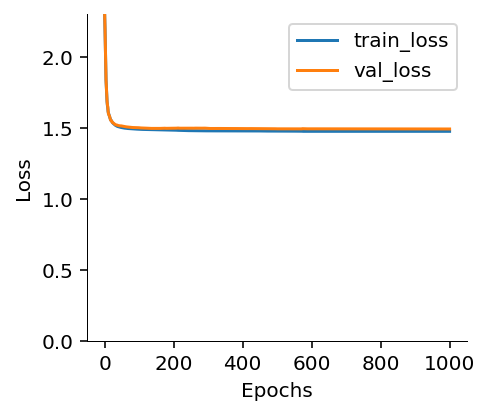

In [31]:
plot_loss(history)

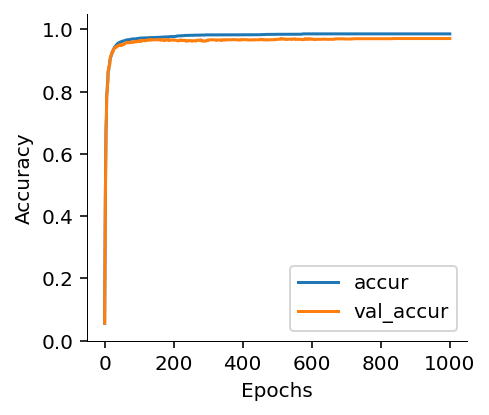

In [32]:
plot_accur(history)

The good news is that the error curves do not seem to diverge and so our model does not seem to be overfit. On the other hand, our neural network does not perform above the random forest baseline so let's crank up the number of neurons and see what happens.

## Using more neurons improves accuracy

In [33]:
model = nn.Sequential(
    nn.Linear(784, 300),
    nn.ReLU(),
    nn.Linear(300, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

In [34]:
history = ctrain1(model, X_train, y_train, X_test, y_test,
                  learning_rate = 0.02, nepochs=1000)

Epoch    0 cross entropy loss  2.3023   test loss  2.3022
Epoch  100 cross entropy loss  1.4839   test loss  1.4935
Epoch  200 cross entropy loss  1.4802   test loss  1.4901
Epoch  300 cross entropy loss  1.4784   test loss  1.4876
Epoch  400 cross entropy loss  1.4750   test loss  1.4857
Epoch  500 cross entropy loss  1.4749   test loss  1.4846
Epoch  600 cross entropy loss  1.4743   test loss  1.4833
Epoch  700 cross entropy loss  1.4739   test loss  1.4837
Epoch  800 cross entropy loss  1.4728   test loss  1.4838
Epoch  900 cross entropy loss  1.4722   test loss  1.4821
Epoch 1000 cross entropy loss  1.4722   test loss  1.4822
LAST       cross entropy loss  1.4722


In [35]:
y_proba = model(X_train)
y_pred = torch.argmax(y_proba, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.989


In [36]:
y_test_proba = model(X_test)
y_test_pred = torch.argmax(y_test_proba, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.979


In [37]:
conf = confusion_matrix(y_test, y_test_pred.detach().numpy())
print(f"VALIDATION CONFUSION MATRIX {test_accur*100:.1f}%")
showmatrix(conf)

VALIDATION CONFUSION MATRIX 97.9%


,$\hat{y}$=0,$\hat{y}$=1,$\hat{y}$=2,$\hat{y}$=3,$\hat{y}$=4,$\hat{y}$=5,$\hat{y}$=6,$\hat{y}$=7,$\hat{y}$=8,$\hat{y}$=9
$y$=0,182,0,1,1,0,0,1,0,0,0
$y$=1,0,209,2,0,0,0,0,0,0,0
$y$=2,0,0,186,0,0,1,1,0,0,0
$y$=3,0,0,1,222,1,1,0,0,1,2
$y$=4,0,0,0,0,198,0,3,1,1,1
$y$=5,0,0,0,1,1,182,1,1,2,0
$y$=6,0,0,0,0,0,0,190,0,0,0
$y$=7,0,1,1,1,1,0,0,204,0,1
$y$=8,0,0,1,1,0,1,0,0,203,0
$y$=9,4,0,1,0,3,0,0,0,0,183


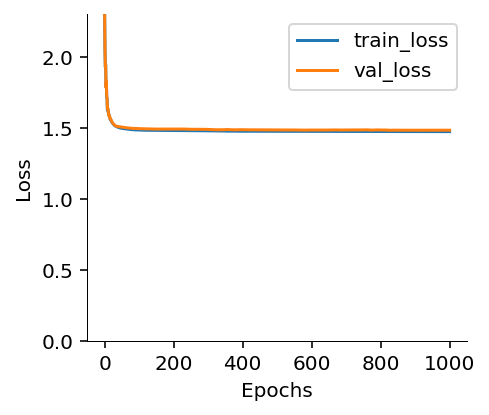

In [38]:
plot_loss(history)

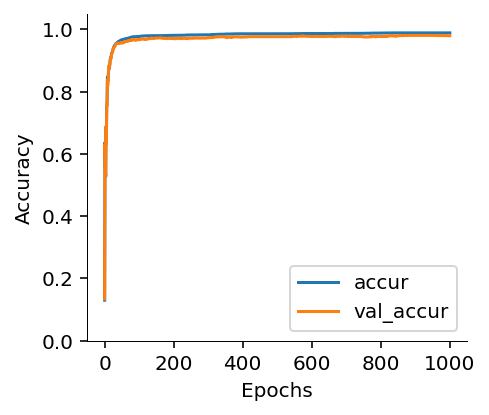

In [39]:
plot_accur(history)

Heh, great! We got a tiny bit more accuracy with more neurons (can vary run-to-run, though). When you are this close to 100% accurate, any improvement is very challenging so this is good.

In the end, vanilla networks are not the most powerful architecture to process images. For that we need [convolutional networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) or CNNs.